# Import DataFrame and Prep Model

In [0]:
#Arrays and Dataframe
import numpy as np
import pandas as pd

#SQL
from sqlalchemy import create_engine

#Visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

#Data Exploration
from scipy import stats

#Data Modeling
from sklearn import linear_model
from sklearn.svm import LinearSVC
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

from statsmodels.tsa.stattools import acf

from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [0]:
#Make SQL Queary
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [0]:
#Drop columns that have a large number of null values (over 30%)
df1 = df.drop(columns = ['alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature'])

In [0]:
#make a copy of df1
df2 = df1.copy()

#interpolate based on the year
year_list = list(df1['yearbuilt'].unique())
for year in year_list:
    df2.loc[df1['yearbuilt']==year] = df2.loc[df1['yearbuilt']==year].interpolate()

# drop missing values that are remaining
df2.dropna(inplace = True)

In [0]:
#update data types
non_numeric = df1.select_dtypes(include = 'object')
numeric = df1.select_dtypes(include = ['float64', 'int64'])


In [0]:
#pick top 5 numeric:
df3 = df2.loc[:, ['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'saleprice']]

In [0]:
#Choose Central Air and External Quality as the features I'll use for the model
df4 = df2.loc[:, ['exterqual', 'centralair', 'mszoning']]

#One Hot encoding of categorical variables
df5 = pd.get_dummies(df4, columns = ['exterqual', 'centralair', 'mszoning'])


In [63]:
#Combine Dataframes
df3
df5
model_df = pd.concat([df3, df5], axis = 1)
df5

,exterqual_Ex,exterqual_Fa,exterqual_Gd,exterqual_TA,centralair_N,centralair_Y,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
0,0,0,1,0,0,1,0,0,0,1,0
1,0,0,0,1,0,1,0,0,0,1,0
2,0,0,1,0,0,1,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,1,0
4,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,1,0,1,0,0,0,1,0
1456,0,0,0,1,0,1,0,0,0,1,0
1457,1,0,0,0,0,1,0,0,0,1,0
1458,0,0,0,1,0,1,0,0,0,1,0


# Create Model


## Run 1st Model

In [0]:
#Separate target variable from rest of data
X = model_df.drop(columns = 'saleprice')
y = model_df['saleprice']

#split train_test
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [53]:
X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

results.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     356.6
Date:                Tue, 05 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:09:23   Log-Likelihood:                -15740.
No. Observations:                1318   AIC:                         3.151e+04
Df Residuals:                    1304   BIC:                         3.158e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3.567e+04   4520.804     -7.891      0.000   -4.45e+04   -2.68e+04
overallqual       1.869e+04   1333.298     14.017      0.000    1.61e+04    2.13e+04
grlivarea           47.5554      2.589     18.366      0.000      42.476      52.635
garagecars        1.597e+04   3122.837      5.113      0.000    9840.567    2.21e+04
garagearea          13.1414     10.473      1.255      0.210      -7.404      33.687
totalbsmtsf         22.4923      3.340      6.735      0.000      15.940      29.044
exterqual_Ex      3.815e+04   6492.987      5.875      0.000    2.54e+04    5.09e+04
exterqual_Fa     -3.203e+04   1.16e+04     -2.750      0.006   -5.49e+04   -9180.004
exterqual_Gd     -1.403e+04   4194.266     -3.344      0.001   -2.23e+04   -5797.302
exterqual_TA     -2.777e+04   3786.221     -7.334      0.000   -3.52e+04   -2.03e+04
centralair_N     -2.681e+04   3577.280     -7.493      0.000   -3.38e+04   -1.98e+04
centralair_Y     -8867.3213   3384.677     -2.620      0.009   -1.55e+04   -2227.313
mszoning_C (all)  -2.15e+04   1.14e+04     -1.878      0.061    -4.4e+04     955.600
mszoning_FV      -1501.5578   5600.882     -0.268      0.789   -1.25e+04    9486.168
mszoning_RH      -5046.5754   9727.162     -0.519      0.604   -2.41e+04     1.4e+04
mszoning_RL       4981.9717   4008.779      1.243      0.214   -2882.390    1.28e+04
mszoning_RM       -1.26e+04   4223.032     -2.984      0.003   -2.09e+04   -4317.711
==============================================================================
Omnibus:                      549.928   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64374.444
Skew:                          -0.917   Prob(JB):                         0.00
Kurtosis:                      37.189   Cond. No.                     3.14e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.58e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

This model has a high F statistic (500). The R-sqared and R-adjusted are around 77%, which means that 77% of the variance can be explained by the current features. The only feauture that seems to be statistically insignificant is garagearea. This will be removed and the model retested. 

## Run Second Model

In [0]:
#Separate target variable from rest of data
X1 = model_df.drop(columns = ['saleprice', 'garagearea'])
y = model_df['saleprice']

In [55]:
X1 = sm.add_constant(X1)

results1 = sm.OLS(y, X1).fit()

results1.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     386.0
Date:                Tue, 05 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:09:23   Log-Likelihood:                -15741.
No. Observations:                1318   AIC:                         3.151e+04
Df Residuals:                    1305   BIC:                         3.158e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3.525e+04   4509.295     -7.818      0.000   -4.41e+04   -2.64e+04
overallqual       1.861e+04   1332.261     13.972      0.000     1.6e+04    2.12e+04
grlivarea           47.8598      2.579     18.561      0.000      42.801      52.918
garagecars        1.883e+04   2129.780      8.843      0.000    1.47e+04     2.3e+04
totalbsmtsf         23.4450      3.253      7.207      0.000      17.063      29.827
exterqual_Ex      3.833e+04   6492.810      5.904      0.000    2.56e+04    5.11e+04
exterqual_Fa     -3.124e+04   1.16e+04     -2.686      0.007   -5.41e+04   -8421.180
exterqual_Gd     -1.433e+04   4187.981     -3.423      0.001   -2.25e+04   -6118.042
exterqual_TA     -2.801e+04   3782.290     -7.405      0.000   -3.54e+04   -2.06e+04
centralair_N     -2.671e+04   3577.178     -7.466      0.000   -3.37e+04   -1.97e+04
centralair_Y     -8545.8295   3375.709     -2.532      0.011   -1.52e+04   -1923.419
mszoning_C (all) -2.053e+04   1.14e+04     -1.797      0.073   -4.29e+04    1880.876
mszoning_FV      -1206.4480   5597.174     -0.216      0.829   -1.22e+04    9773.996
mszoning_RH      -5075.6985   9729.275     -0.522      0.602   -2.42e+04     1.4e+04
mszoning_RL       4654.7554   4001.169      1.163      0.245   -3194.672    1.25e+04
mszoning_RM      -1.309e+04   4205.939     -3.113      0.002   -2.13e+04   -4840.253
==============================================================================
Omnibus:                      534.285   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            60553.856
Skew:                          -0.867   Prob(JB):                         0.00
Kurtosis:                      36.161   Cond. No.                     4.47e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.58e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The F statistic improved with the removal of garagearea. R-squared and r-adjusted remained the same. AIC remained the same while BIC had a minor improvement. 

## Run 3rd Model

In [0]:
#Separate target variable from rest of data - also remove central air
X2 = model_df.drop(columns = ['saleprice', 'garagearea', 'centralair_N', 'centralair_Y'])
y = model_df['saleprice']

In [57]:
X2 = sm.add_constant(X2)

results2 = sm.OLS(y, X2).fit()

results2.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     416.5
Date:                Tue, 05 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:09:23   Log-Likelihood:                -15747.
No. Observations:                1318   AIC:                         3.152e+04
Df Residuals:                    1306   BIC:                         3.158e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -4.619e+04   6078.666     -7.598      0.000   -5.81e+04   -3.43e+04
overallqual       1.908e+04   1330.746     14.339      0.000    1.65e+04    2.17e+04
grlivarea           46.9824      2.576     18.236      0.000      41.928      52.037
garagecars        1.894e+04   2138.301      8.858      0.000    1.47e+04    2.31e+04
totalbsmtsf         23.9195      3.263      7.329      0.000      17.517      30.322
exterqual_Ex      3.664e+04   6685.580      5.480      0.000    2.35e+04    4.98e+04
exterqual_Fa     -3.817e+04   1.17e+04     -3.257      0.001   -6.12e+04   -1.52e+04
exterqual_Gd     -1.547e+04   4216.661     -3.670      0.000   -2.37e+04   -7202.476
exterqual_TA     -2.917e+04   3635.430     -8.025      0.000   -3.63e+04    -2.2e+04
mszoning_C (all) -2.595e+04   1.15e+04     -2.259      0.024   -4.85e+04   -3414.002
mszoning_FV       -317.3065   5577.877     -0.057      0.955   -1.13e+04    1.06e+04
mszoning_RH      -1.124e+04   9785.204     -1.149      0.251   -3.04e+04    7952.008
mszoning_RL       5514.8501   3928.075      1.404      0.161   -2191.176    1.32e+04
mszoning_RM      -1.419e+04   4207.209     -3.373      0.001   -2.24e+04   -5938.764
==============================================================================
Omnibus:                      528.382   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57987.000
Skew:                          -0.854   Prob(JB):                         0.00
Kurtosis:                      35.450   Cond. No.                     4.34e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.73e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

This model improved only on f statistic but was not performing better in terms of r-squared and r-adjusted, or BIC/AIC.

I think the 2nd model is a satisfactory model because it explains 77% of the variance. If we get much higher than this, we run the risk of overfitting. 

## Run 4th Model
Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
Is the performance of your model satisfactory? Why?
Try to improve your model in terms of predictive performance by adding or removing some variables.
Please submit a link your work notebook. This is not a graded checkpoint, but you should discuss your solutions with your mentor. Also, when you're done, compare your work to this example solution.

In [0]:
#Separate target variable from rest of data
X3 = model_df.drop(columns = ['saleprice', 'garagearea'])
y3 = model_df['saleprice']

#split train_test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3)

In [59]:
X_train3 = sm.add_constant(X_train3)

results3 = sm.OLS(y_train3, X_train3).fit()

results3.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     330.2
Date:                Tue, 05 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:09:23   Log-Likelihood:                -11718.
No. Observations:                 988   AIC:                         2.346e+04
Df Residuals:                     975   BIC:                         2.353e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -3.73e+04   4636.493     -8.045      0.000   -4.64e+04   -2.82e+04
overallqual       1.746e+04   1392.263     12.544      0.000    1.47e+04    2.02e+04
grlivarea           50.6145      2.804     18.049      0.000      45.111      56.117
garagecars        1.523e+04   2312.377      6.587      0.000    1.07e+04    1.98e+04
totalbsmtsf         35.4812      3.675      9.655      0.000      28.269      42.693
exterqual_Ex      3.161e+04   7021.382      4.502      0.000    1.78e+04    4.54e+04
exterqual_Fa     -2.814e+04    1.3e+04     -2.166      0.031   -5.36e+04   -2643.029
exterqual_Gd      -1.32e+04   4630.524     -2.851      0.004   -2.23e+04   -4114.714
exterqual_TA     -2.757e+04   4177.352     -6.600      0.000   -3.58e+04   -1.94e+04
centralair_N     -2.825e+04   3798.887     -7.437      0.000   -3.57e+04   -2.08e+04
centralair_Y     -9051.9244   3552.747     -2.548      0.011    -1.6e+04   -2080.014
mszoning_C (all) -1.764e+04   1.15e+04     -1.532      0.126   -4.02e+04    4959.910
mszoning_FV        621.6904   5837.800      0.106      0.915   -1.08e+04    1.21e+04
mszoning_RH      -9940.0506   9997.355     -0.994      0.320   -2.96e+04    9678.760
mszoning_RL       2246.5312   4246.893      0.529      0.597   -6087.571    1.06e+04
mszoning_RM      -1.259e+04   4434.966     -2.838      0.005   -2.13e+04   -3882.922
==============================================================================
Omnibus:                      262.631   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17684.025
Skew:                          -0.074   Prob(JB):                         0.00
Kurtosis:                      23.726   Cond. No.                     2.58e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.66e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [60]:
X_test3 = sm.add_constant(X_test3)

# We are making predictions here
y_preds3 = results3.predict(X_test3)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


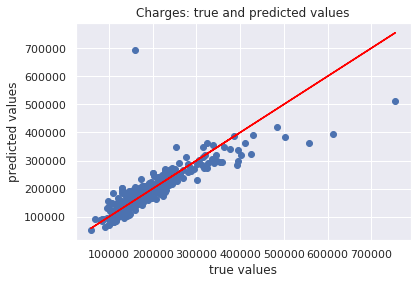

Mean absolute error of the prediction is: 24422.856726807386
Mean squared error of the prediction is: 2093670649.1824822
Root mean squared error of the prediction is: 45756.645956434375
Mean absolute percentage error of the prediction is: 12.997030661278133


In [61]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
plt.scatter(y_test3, y_preds3)
plt.plot(y_test3, y_test3, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test3, y_preds3)))
print("Mean squared error of the prediction is: {}".format(mse(y_test3, y_preds3)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test3, y_preds3)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test3 - y_preds3) / y_test3)) * 100))

## Run 5th Model

In [0]:
#Separate target variable from rest of data
X4 = model_df.drop(columns = ['saleprice', 'garagearea', 'mszoning_C (all)', 'mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM'])
y4 = model_df['saleprice']

#split train_test
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4)

In [75]:
X_train4 = sm.add_constant(X_train4)

results4 = sm.OLS(y_train4, X_train4).fit()

results4.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     428.4
Date:                Tue, 05 Nov 2019   Prob (F-statistic):          1.49e-313
Time:                        22:13:10   Log-Likelihood:                -11786.
No. Observations:                 988   AIC:                         2.359e+04
Df Residuals:                     979   BIC:                         2.363e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.913e+04   5406.245     -7.239      0.000   -4.97e+04   -2.85e+04
overallqual   1.858e+04   1492.337     12.448      0.000    1.56e+04    2.15e+04
grlivarea       49.0319      2.914     16.828      0.000      43.314      54.750
garagecars        2e+04   2396.654      8.344      0.000    1.53e+04    2.47e+04
totalbsmtsf     23.0133      3.579      6.430      0.000      15.990      30.037
exterqual_Ex  4.231e+04   7378.585      5.734      0.000    2.78e+04    5.68e+04
exterqual_Fa -4.092e+04   1.22e+04     -3.352      0.001   -6.49e+04    -1.7e+04
exterqual_Gd   -1.4e+04   4405.456     -3.177      0.002   -2.26e+04   -5349.819
exterqual_TA -2.653e+04   3859.324     -6.873      0.000   -3.41e+04    -1.9e+04
centralair_N -3.176e+04   3991.809     -7.956      0.000   -3.96e+04   -2.39e+04
centralair_Y -7374.2643   3823.889     -1.928      0.054   -1.49e+04     129.698
==============================================================================
Omnibus:                      435.273   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50420.563
Skew:                          -0.999   Prob(JB):                         0.00
Kurtosis:                      37.940   Cond. No.                     3.09e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.01e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [76]:
X_test4 = sm.add_constant(X_test4)

# We are making predictions here
y_preds4 = results4.predict(X_test4)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


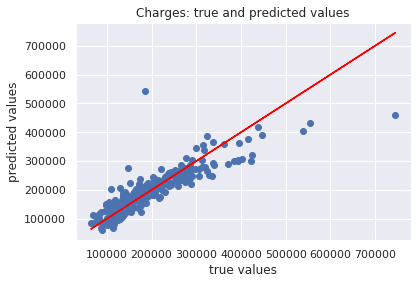

Mean absolute error of the prediction is: 24215.92640811957
Mean squared error of the prediction is: 1394311933.628577
Root mean squared error of the prediction is: 37340.48652104813
Mean absolute percentage error of the prediction is: 13.134976426210601


In [78]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
plt.scatter(y_test4, y_preds4)
plt.plot(y_test4, y_test4, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test3, y_preds3)))
print("Mean squared error of the prediction is: {}".format(mse(y_test3, y_preds3)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test3, y_preds3)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test3 - y_preds3) / y_test3)) * 100))

This produced slightly better results. 